In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# Import torch libraries
import torch
import torch.nn as nn
from torch.optim import Adam

# Import stochastic interpolation custom libs
import flowtrain.utils as utils 
import flowtrain.models as mdl
import flowtrain.dataloaders as dl
import flowtrain.interpolation as intrp

# Check if on PC or GPU cluster
import platform

# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);

### Find Device

Check if on cluster (Linux) or on PC (Windows) and get a device accordingly. 

In [5]:
system_name = platform.system()
print(f"System: {system_name}")

if system_name == 'Windows':
    # Set default tensor type to GPU
    if torch.cuda.is_available():
        torch.set_default_device('cuda')
        
    device='cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using {device} device")
    
if system_name == 'Linux':
    device = 2

System: Linux


## Load and Inspect Data

Choose a dataset, the training module dataloaders file has some datasets that have been adapted for generative modeling. For this exercise, we use the FashionMNIST set to train on smaller images for early experimentation.

The dataloaders provide normalized data. So to view the data a denormalization is required. Many of the display functions have this built in for simple grayscale images.

images tensor is torch.Size([16, 1, 32, 32])


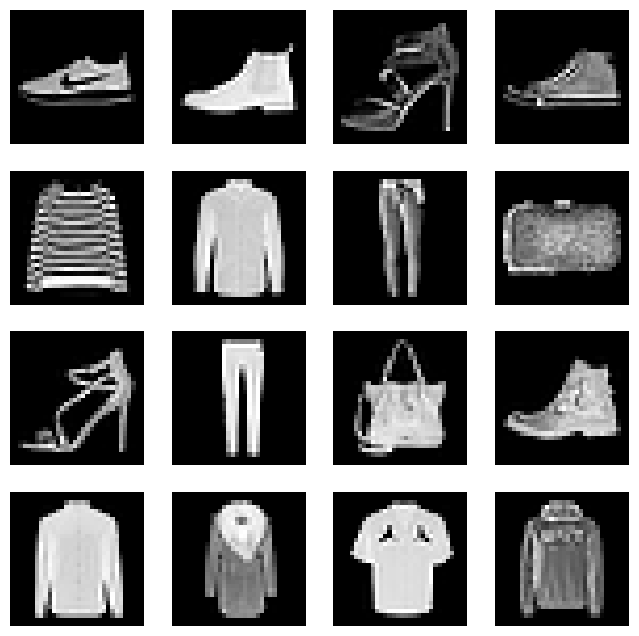

In [6]:
# simple black and white images   
batch_size = 16
dataloader = dl.get_fashion_mnist(batch_size=batch_size, device='cpu')
utils.show_first_batch(dataloader, denormalize=True)

## Define a Stochastic Interpolant Scheduler

The full list of stochasitic interpolants shown below have been implemented. A stochastic interpolator object requires a choice of interpolant and can handle returning batches of XT, BT, ST, VT which are functions of T, XO, X1, Z 

![](https://i.imgur.com/QpWM2lT.png)

![](https://i.imgur.com/ka5kdRW.png)

**Page 27**
Albergo, M. S., Boffi, N. M., & Vanden-Eijnden, E. (2023). Stochastic Interpolants: A Unifying Framework for Flows and Diffusions (No. arXiv:2303.08797). arXiv. http://arxiv.org/abs/2303.08797


For this model the linear one-sided interpolant with ODE is used as a simpler starting case.

In [7]:
# Specify the interpolant scheme to be used
interpolant = intrp.LinearInterpolant(one_sided=True, gamma_a=1.)
# Load the interpolator
interp = intrp.StochasticInterpolator(interpolant=interpolant)

### Check correct functioning with visual libraries

Some utilites are available to verify the effect of the interpolator

In [5]:
# Get a batch of images
batch = next(iter(dataloader))
# Get a batch of noise
X0 = torch.randn_like(batch)

Showing interpolation from noise to images

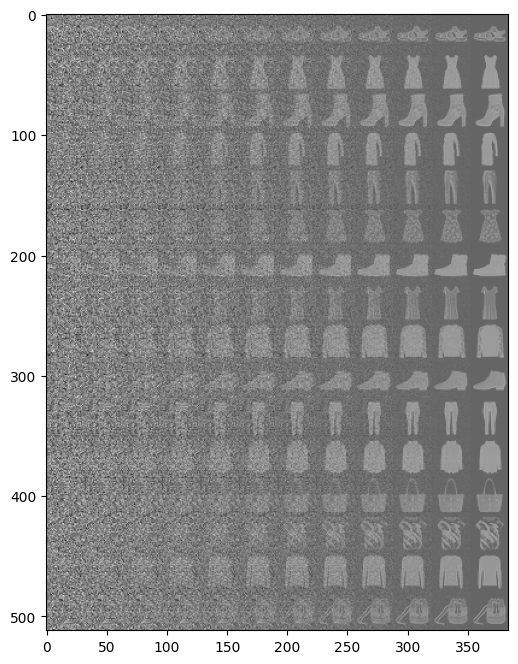

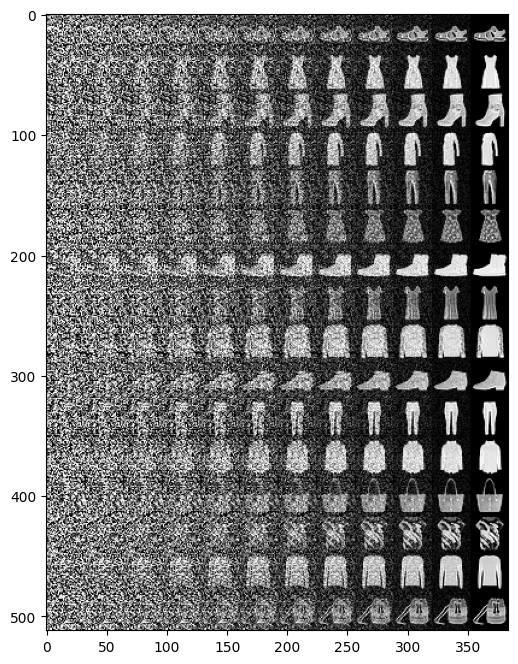

Returned images frames are a TxNxCxHxW tensor: shape torch.Size([12, 16, 1, 32, 32])


In [6]:
image_frames, time_frames = utils.make_interpolation_sequence(interp, X0, batch, Z=None, n_steps=12)

# Display again but normalized
utils.show_time_series(image_frames, denormalize=True)
print(f"Returned images frames are a TxNxCxHxW tensor: shape {image_frames.shape}")

We can also animate a batch that is in TNCHW tensor dimensions, such as above, but also an ODE series of images

In [7]:
utils.animate_batch(image_frames, save_path="sample_interpolator.gif", denormalize=True)

Sampling at time t=.5 and then verifying the interpolation and model velocity

images tensor is torch.Size([16, 1, 32, 32])


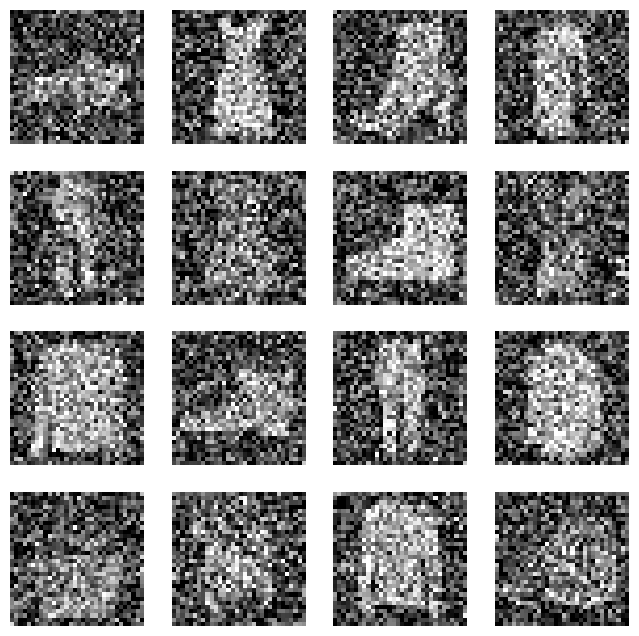

images tensor is torch.Size([16, 1, 32, 32])


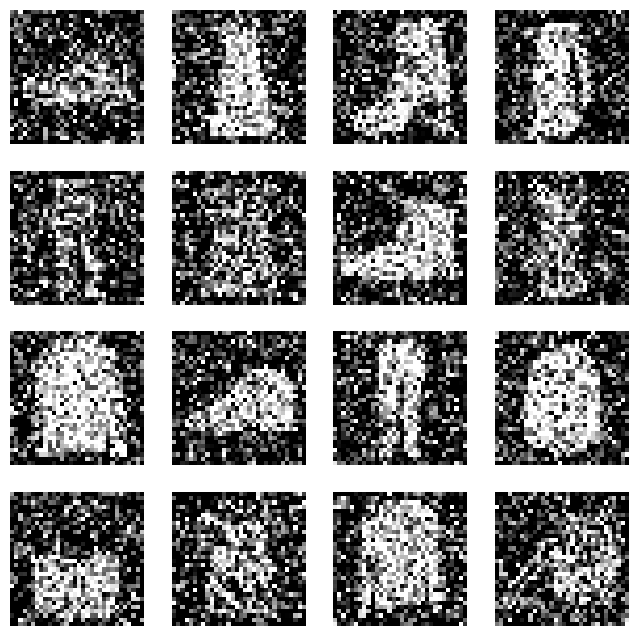

In [8]:
X1 = batch.to(device)
X0 = torch.randn_like(X1).to(device)
t = .5
T = torch.ones(X1.size(0)).to(device)*t

XT, BT = interp.flow_objective(T, X0, X1)
# Show a random sample at t
utils.show_images(XT)
utils.show_images(BT)

The two-sided models require a noise factor and two endpoints

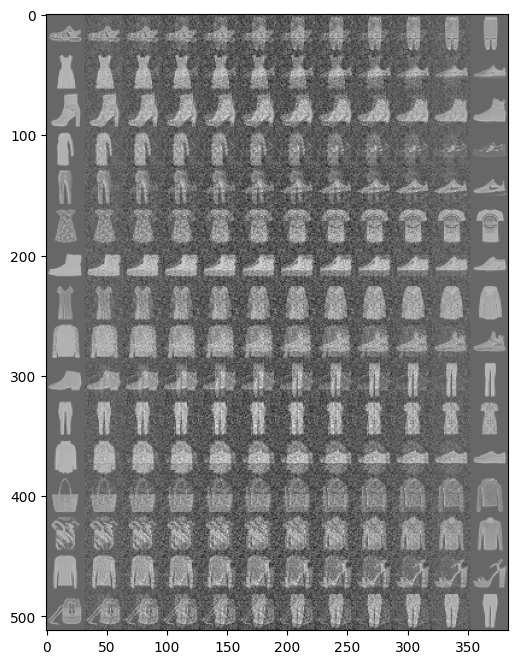

In [8]:
# Specify the interpolant scheme to be used
interpolant = intrp.TrigInterpolant(one_sided=False, gamma_a=1.)
# Load the interpolator
interp = intrp.StochasticInterpolator(interpolant=interpolant)

# Fetch two batches of images
batch_getter = iter(dataloader)
X0 = next(batch_getter).to(device)
X1 = next(batch_getter).to(device)

# Make a latent variable
Z = torch.randn_like(X0).to(device)

# Interpolate between the two batches
image_frames, time_frames = utils.make_interpolation_sequence(interp, X0, X1, Z=Z, n_steps=12)

## Define a Model

The Denoising Diffusion Model library Unet is being used. It is a very flexible model with advanced options included in it. For the sake of repeatability, model parameters are being stored in the models file along with save and load funtionality. To demonstrate the instatiation of the Unet, both forms are shown


In [ ]:
from flowtrain.models import Unet2D

model_params = {
    'dim'              : 64,             # Base number of hidden channels in model
    'dim_mults'        : (1, 2,2,2),      # Multipliers for hidden dims in each superblock, total 2x downsamples = len(dim_mults)-1
    'data_channels'    : 1,              # Data clamped down to 22 channels -1 to 20, with -1 "sky/air" category
    'dropout'          : 0.,              # Optional network dropout
    'self_condition'   : False,           # Optional conditioning on input data
    'time_resolution'  : 128,             # Resolution of time (number of random Fourier features)        
    'time_bandwidth'   : 100.,            # Starting bandwidth of fourier frequencies, f ~ N(0, time_bandwidth)
    'time_learned_emb' : True,            # Learnable fourier freqs and phases

    'attn_enabled'     : True,            # Enable or disable self attention before each (down/up sample) also feeds skip connections 
    'attn_dim_head'    : 32,              # Size of attention hidden dimension heads
    'attn_heads'       : 4,               # Number of chunks to split hidden dimension into for attention
    'full_attn'        : None,            # defaults to full attention only for inner most layer final down, middle, first up
    'flash_attn'       : False            # For high performance GPUs https://github.com/Dao-AILab/flash-attention
}      


model = Unet2D(**model_params).to(device)

config ={}
""" Black and white 32x32, Works for fashion mnist """
config['batch_size'] = 512
config['IMAGE_SIZE'] = (1,32,32)
config['training_steps'] = 1e5
config['learning_rate'] = 2e-4

interpolator = intrp.StochasticInterpolator(intrp.LinearInterpolant(one_sided=True, gamma_a=1.))

In [10]:
print(model.__class__.__name__)
print(interpolator)
print(config)

Unet2D
StochasticInterpolator(LinearInterpolant(one_sided=True))
{'batch_size': 512, 'IMAGE_SIZE': (1, 32, 32), 'training_steps': 100000.0, 'learning_rate': 0.0002}


## Choose a Learning Objective



For this case the $b$ field will be learned. But the same principles can apply to learning ST, VT, Denosing, etc.

To learn this objective, set the values for position and velocity 

$x(t) = \alpha(t) x_0 + \beta(t) x_1 + \gamma(t) z$

$b(t,x) = \dot \alpha(t) x_0 + \dot \beta(t) x_1 + \dot \gamma(t) z$  

The loss above is the same minimizer for 
$$\min_{\theta} \mathbb{E}\frac{1}{2}\|\hat b - b \|^2$$
Since we can rewrite this as $$\min_{\theta} \mathbb{E} \frac{1}{2}\|\hat b - b \|^2 = \min_{\theta} \frac{1}{2}\mathbb{E} [\hat b ^2 -2 \hat b b + b^2 ] = \min_{\theta} \mathbb{E} [\frac{1}{2}\hat b ^2- \hat b b]$$
So to formulate the loss in a simpler way it is sufficient to predict the velocity and minimize the MSE with the actual velocity.

The Interpolator has a built in function to take a vector of N times and and a batch of NxCxHxW shape for X0, X1, and Z where applicable to form the XT and BT truth values for training


## Setup training

In [11]:
from torch.optim.lr_scheduler import ExponentialLR
import os


# Overwrite batch size
config["batch_size"] = 512
dataloader = dl.get_fashion_mnist(batch_size=config["batch_size"], device='cpu')

criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=config['learning_rate'])
scheduler = ExponentialLR(optimizer, gamma=0.99)
num_epochs = 20

MODELS_DIR = "saved_models"
MODEL_NAME = "demo"
path = os.path.join(MODELS_DIR, MODEL_NAME)

The model and interpolator get saved together in the same folder with model library

In [13]:
save_path = path + "/demo_model.pth"
mdl.save_model(model, save_path)

In [14]:
# The model is saved as a dictionary 
model = mdl.load_model(model, save_path)
model.to(device);

Loaded model from saved_models/demo/demo_model.pth


## Training Definitions

Training functions for the velocity $b_t$ objective and for the 

In [15]:
import wandb
from tqdm import tqdm

def train_stochastic_model_BT(
    model,
    config,
    interpolator,
    optimizer,
    criterion,
    dataloader,
    num_epochs,
    path,
    device,
    scheduler=None,
    wandb_log=True,
    antithetic=False,
):

    if wandb_log:
        wandb.login()
        run = wandb.init(
            project=path.split("/")[-1],
            config={
                "learning_rate": optimizer.param_groups[0]["lr"],
                "epochs": num_epochs,
            },
            settings=wandb.Settings(console="off", silent=True),
        )

    # Ensure the directory exists for model
    os.makedirs(os.path.dirname(path), exist_ok=True)

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0
        progress = tqdm(
            enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch + 1}/{num_epochs}"
        )
        for i, data in progress:
            # Gather interpolated samples and velocities
            X1 = data.to(device)
            X0 = torch.randn_like(X1).to(device)
            T = torch.rand(X1.size(0)).to(device)
            XT, BT = interpolator.flow_objective(T, X0, X1)

            # Predict the correct velocities with time embedding
            optimizer.zero_grad()
            B_hat_T = model(XT, T)
            # Compute the loss
            loss = criterion(B_hat_T, BT)

            if antithetic:
                # Antithetic sampling
                XT, BT = interpolator.flow_objective(T, -X0, X1)
                B_hat_T = model(XT, T)
                loss += criterion(B_hat_T, BT)
                loss /= 2

            loss.backward()
            # Gradient clipping for DNN
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()
            # Update progress bar with the current average loss
            progress.set_postfix(loss=running_loss / (i + 1))

        if scheduler is not None:
            scheduler.step()

        if wandb_log:
            wandb.log(
                {
                    "loss": running_loss / len(dataloader),
                    "learning_rate": scheduler.get_last_lr()[0],
                }
            )

        save_file = os.path.join(path, f"last_epoch.pth")
        # Save the model and its configuration
        torch.save(model.state_dict(), save_file)

        if (epoch + 1) % 20 == 0:
            save_file = os.path.join(path, f"epoch_{epoch + 1}.pth")
            # Save the model and its configuration
            torch.save(model.state_dict(), save_file)
            print(f"Model and configuration saved to {path}")

    run.finish()

In [ ]:
TRAIN = False
if TRAIN:
    train_stochastic_model_BT(model, config, interpolator, optimizer, criterion, 
                         dataloader, num_epochs, path, device, scheduler=scheduler, wandb_log=False)

Epoch 9/300:   3%|▎         | 3/118 [00:02<01:38,  1.17it/s, loss=0.181]


KeyboardInterrupt: 

## Load a trained model

In [13]:
MODELS_DIR = "saved_models"
MODEL_NAME = "unet_mnist_linear_interpolant_b"
file_path = os.path.join(MODELS_DIR, MODEL_NAME, "model_full.pth")
model = mdl.load_model(model, file_path)
model.to(device);

print(f"Model: {model._get_name()}")
print(interpolator)
print(config)

RuntimeError: Error(s) in loading state_dict for Unet2D:
	Missing key(s) in state_dict: "time_mlp.0.freqs", "time_mlp.0.phases". 
	Unexpected key(s) in state_dict: "time_mlp.0.weights". 
	size mismatch for time_mlp.1.weight: copying a param with shape torch.Size([512, 17]) from checkpoint, the shape in current model is torch.Size([512, 128]).
	size mismatch for downs.0.2.mem_kv: copying a param with shape torch.Size([2, 4, 32, 4]) from checkpoint, the shape in current model is torch.Size([2, 4, 64, 4]).
	size mismatch for downs.0.2.to_qkv.weight: copying a param with shape torch.Size([384, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 128, 1, 1]).
	size mismatch for downs.0.2.to_out.0.weight: copying a param with shape torch.Size([128, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 256, 1, 1]).
	size mismatch for downs.1.2.mem_kv: copying a param with shape torch.Size([2, 4, 32, 4]) from checkpoint, the shape in current model is torch.Size([2, 4, 64, 4]).
	size mismatch for downs.1.2.to_qkv.weight: copying a param with shape torch.Size([384, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 128, 1, 1]).
	size mismatch for downs.1.2.to_out.0.weight: copying a param with shape torch.Size([128, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 256, 1, 1]).
	size mismatch for downs.2.2.mem_kv: copying a param with shape torch.Size([2, 4, 32, 4]) from checkpoint, the shape in current model is torch.Size([2, 4, 64, 4]).
	size mismatch for downs.2.2.to_qkv.weight: copying a param with shape torch.Size([384, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 256, 1, 1]).
	size mismatch for downs.2.2.to_out.0.weight: copying a param with shape torch.Size([256, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).
	size mismatch for downs.3.2.mem_kv: copying a param with shape torch.Size([2, 4, 4, 32]) from checkpoint, the shape in current model is torch.Size([2, 4, 4, 64]).
	size mismatch for downs.3.2.to_qkv.weight: copying a param with shape torch.Size([384, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 256, 1, 1]).
	size mismatch for downs.3.2.to_out.weight: copying a param with shape torch.Size([256, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).
	size mismatch for ups.0.2.mem_kv: copying a param with shape torch.Size([2, 4, 4, 32]) from checkpoint, the shape in current model is torch.Size([2, 4, 4, 64]).
	size mismatch for ups.0.2.to_qkv.weight: copying a param with shape torch.Size([384, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 256, 1, 1]).
	size mismatch for ups.0.2.to_out.weight: copying a param with shape torch.Size([256, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).
	size mismatch for ups.1.2.mem_kv: copying a param with shape torch.Size([2, 4, 32, 4]) from checkpoint, the shape in current model is torch.Size([2, 4, 64, 4]).
	size mismatch for ups.1.2.to_qkv.weight: copying a param with shape torch.Size([384, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 256, 1, 1]).
	size mismatch for ups.1.2.to_out.0.weight: copying a param with shape torch.Size([256, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).
	size mismatch for ups.2.2.mem_kv: copying a param with shape torch.Size([2, 4, 32, 4]) from checkpoint, the shape in current model is torch.Size([2, 4, 64, 4]).
	size mismatch for ups.2.2.to_qkv.weight: copying a param with shape torch.Size([384, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 256, 1, 1]).
	size mismatch for ups.2.2.to_out.0.weight: copying a param with shape torch.Size([256, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).
	size mismatch for ups.3.2.mem_kv: copying a param with shape torch.Size([2, 4, 32, 4]) from checkpoint, the shape in current model is torch.Size([2, 4, 64, 4]).
	size mismatch for ups.3.2.to_qkv.weight: copying a param with shape torch.Size([384, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 128, 1, 1]).
	size mismatch for ups.3.2.to_out.0.weight: copying a param with shape torch.Size([128, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 256, 1, 1]).
	size mismatch for mid_attn.mem_kv: copying a param with shape torch.Size([2, 4, 4, 32]) from checkpoint, the shape in current model is torch.Size([2, 4, 4, 64]).
	size mismatch for mid_attn.to_qkv.weight: copying a param with shape torch.Size([384, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 256, 1, 1]).
	size mismatch for mid_attn.to_out.weight: copying a param with shape torch.Size([256, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).

## Test model inference

This is a good way to compare model prediction against the true value for a given time frame and to see if it is somewhat correct.

images tensor is torch.Size([512, 1, 32, 32])


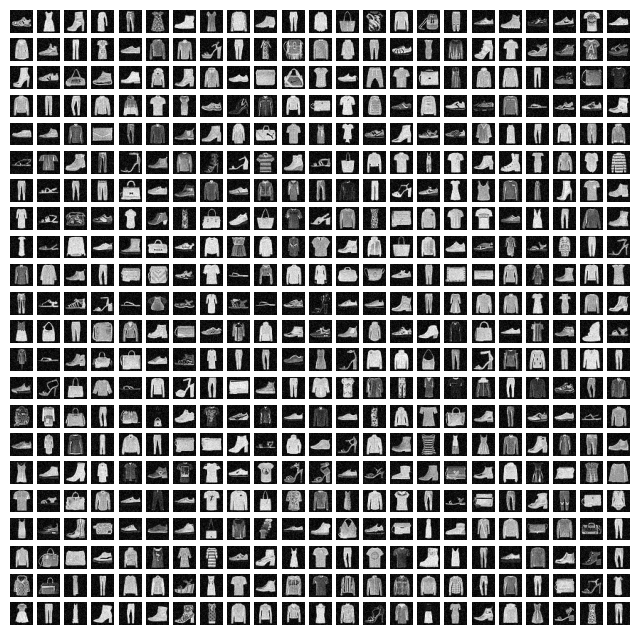

images tensor is torch.Size([512, 1, 32, 32])


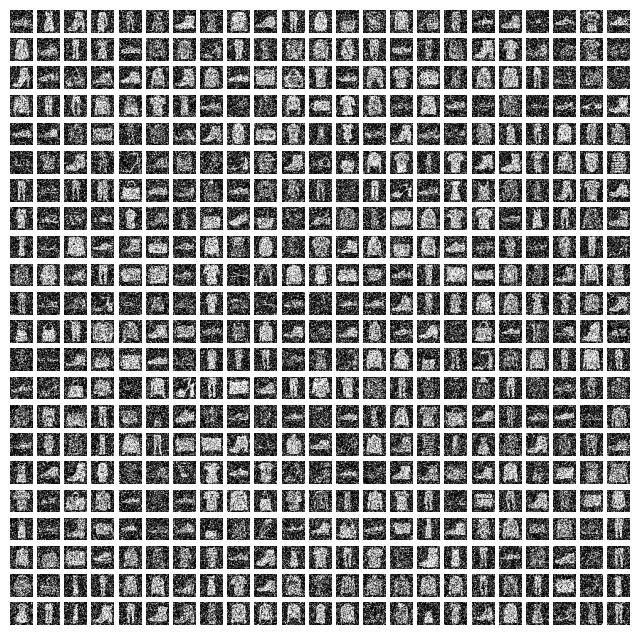

images tensor is torch.Size([512, 1, 32, 32])


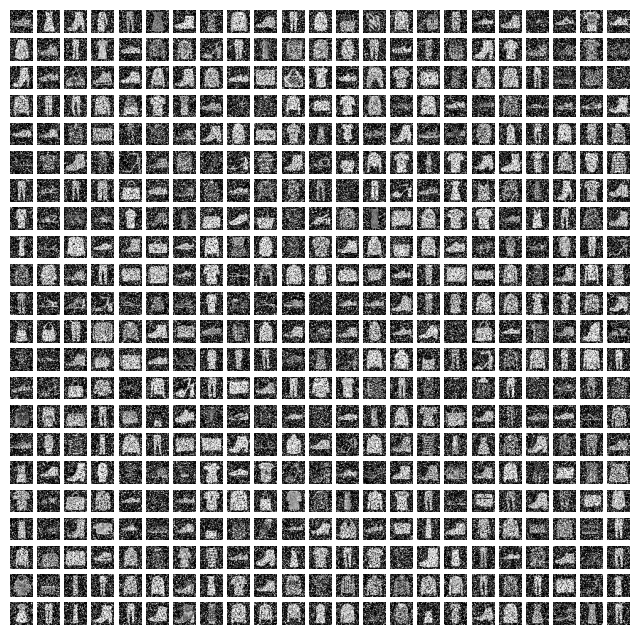

images tensor is torch.Size([512, 1, 32, 32])


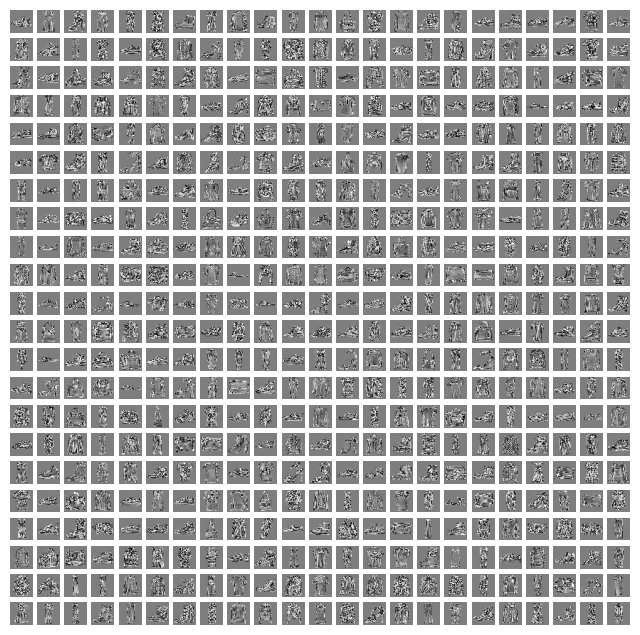

In [27]:
# Test the model by loading a batch adding time to get XT and BT and then plotting the images
for data in dataloader:
    X1 = data.to(device)
    X0 = torch.randn_like(X1).to(device)
    T = torch.ones(X1.size(0)).to(device)*.9
    XT, BT = interpolator.flow_objective(T, X0, X1)
    break

utils.show_images(XT)
utils.show_images(BT)
with torch.no_grad():
    BT_hat = model(XT, T)

utils.show_images(BT_hat)
# compare the differences between the predicted and actual velocities
diff = BT - BT_hat
utils.show_images(diff)

## Generate New Samples with ODE

An existing framework for solving ODEs on pytorch tensors is used to generate the new samples.

The solver is wrapped in a class that holds the model and the scheme for solving given a BT field (ODE Flow). Since the model was trained starting with random noise, in this case that is also the starting distribution for X0.

The solver will integrate the ODE from t=0 to t=1 and return the final image. Since it is in torch it also accepts a batch of images.

The model must be configured to take model(XT, T) as an input and return BT_hat.

In [19]:
solver = mdl.ODEFlowSolver(model)

In [21]:
# Random noise seed
Z = torch.randn(16, 1, 32, 32).to(device)
solution = solver.solve(Z, n_steps=100)   
print(f"Solution on device: {solution.device}") 
print(f"Shape of solution is: {solution.shape}")
solution = solution.cpu()

Solution on device: cuda:0
Shape of solution is: torch.Size([100, 16, 1, 32, 32])


View the static final solution:

images tensor is torch.Size([16, 1, 32, 32])


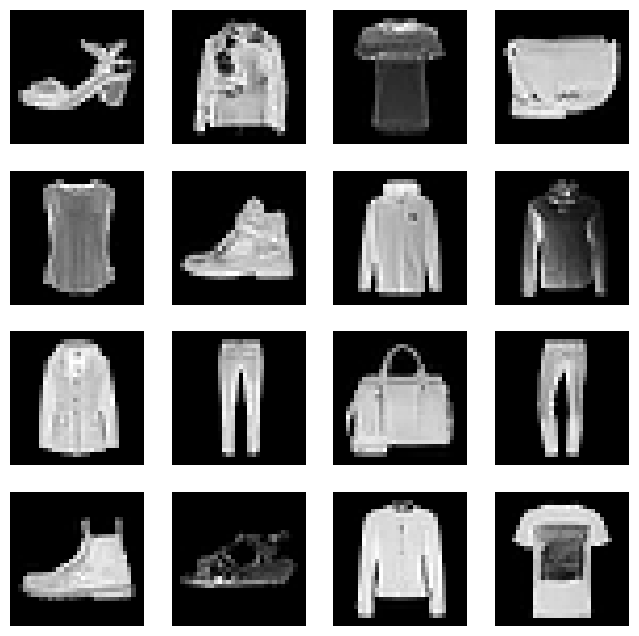

In [22]:
final_frame = solution[-1]
utils.show_images(final_frame, denormalize=True)

View an animation of the time series, saved to gif

In [23]:
utils.animate_batch(solution, "mnist_sample.gif", denormalize=True)

## Analyse solutions

Now we check the nearest neighbours for the batch and display them along with the orignal image.

Generated image shape is: torch.Size([16, 1, 32, 32])


Finding nearest neighbors: 100%|██████████| 118/118 [00:06<00:00, 17.53it/s, Total Count=60000/60000]


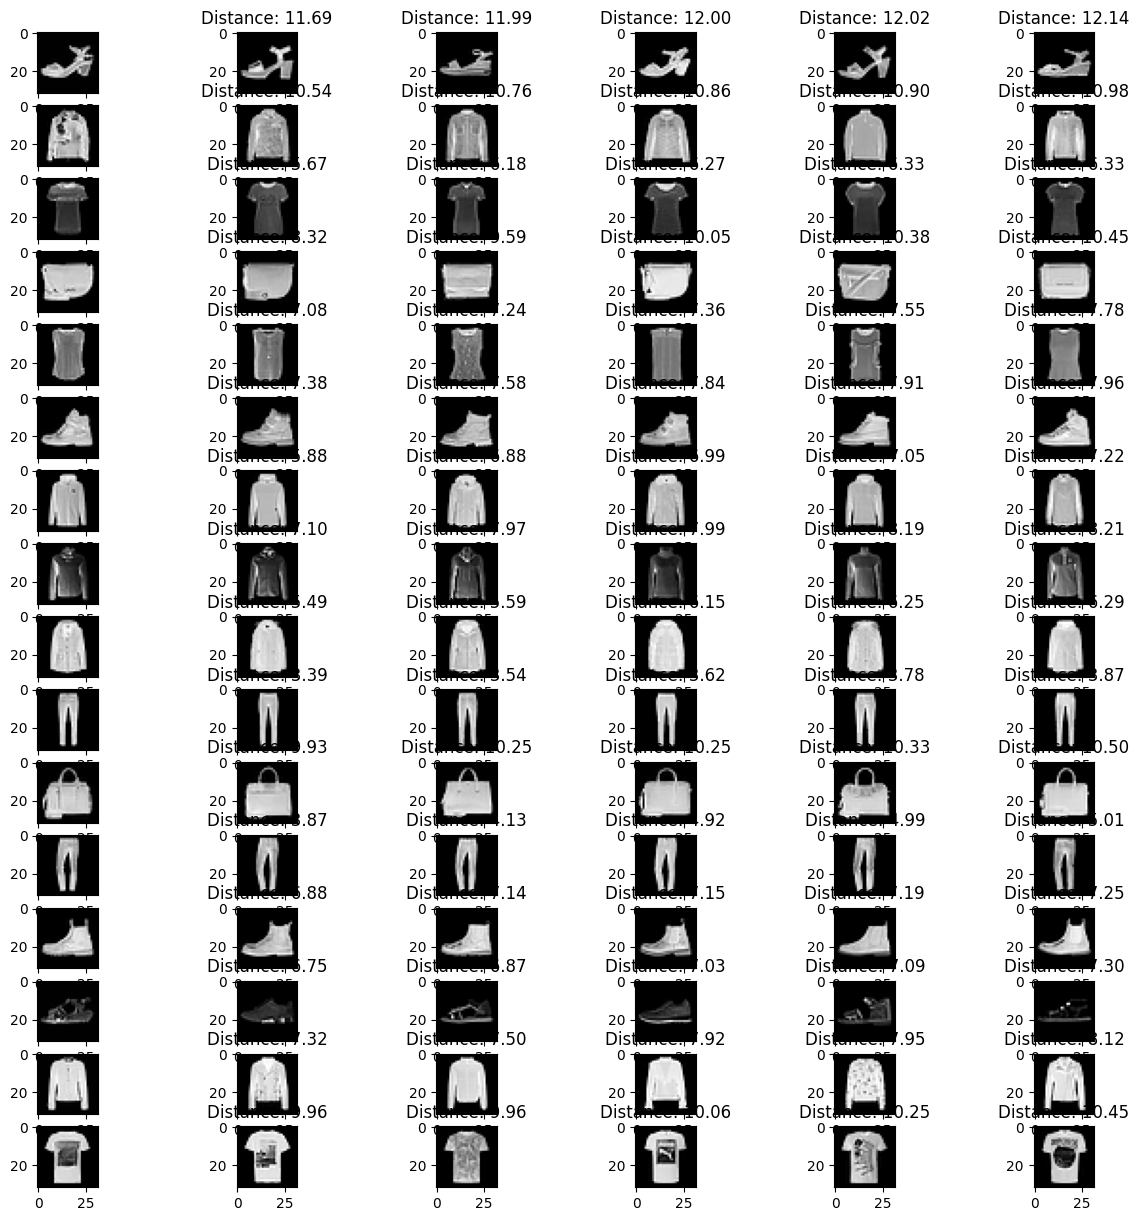

In [24]:
# Last time entry for final images
generated_image = solution[-1]
print(f"Generated image shape is: {generated_image.shape}")

batch_size = len(generated_image)
num_neighbors = 5
# Prepare a plot that is rows with 5 cols
fig, axs = plt.subplots(batch_size, num_neighbors+1, figsize=(15, 15))

for j, generated_image in enumerate(solution[-1]):
    nearest_images, distances = utils.find_nearest_neighbors(generated_image, dataloader, num_neighbors=num_neighbors)
    # Put original image in the first column
    axs[j, 0].imshow(generated_image.squeeze().cpu().numpy(), cmap='gray')
    
    # Show the nearest neighbors
    for i, (image, distance) in enumerate(zip(nearest_images, distances)):
        axs[j, i+1].imshow(image.squeeze().cpu().numpy(), cmap='gray')
        axs[j, i+1].set_title(f"Distance: {distance:.2f}")

plt.show()      
    